# **House Prices - Advanced Regression Techniques**

本ノートブックでは、  
Kaggleコンペティション「**House Prices - Advanced Regression Techniques**」のデータセットを使用し、  
家の価格を予測する**機械学習モデルのベースライン**を構築しております。  
本ベースラインでは、  
**RandomForestRegressor**を使ったシンプルなモデルからスタートし、  
今後の改善や特徴量エンジニアリングの土台としております。

### ◆ 前準備

#### モジュール・ライブラリの読み込み

In [1]:
# モジュール・ライブラリの読み込み
from pathlib import Path
from google.colab import files
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

# warningの非表示
import warnings
warnings.filterwarnings('ignore')
# dfの表示設定
pd.set_option('display.max_columns', None)

#### Pathの設定

In [2]:
# Pathの設定
path = Path(".")
data_path = path / "data"
input_path = data_path / "input"
output_path = data_path / "output"

# フォルダの作成
input_path.mkdir(parents=True, exist_ok=True)
output_path.mkdir(parents=True, exist_ok=True)

#### データセットの読み込みと設定

In [ ]:
# kaggle.jsonのアップロード
files.upload()

In [4]:
# kaggle.json用のフォルダ作成
!mkdir -p ~/.kaggle
# kaggle.jsonの移動
!cp kaggle.json ~/.kaggle/
# アクセス権限の許可
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# データセット.zipのダウンロード
!kaggle competitions download -c house-prices-advanced-regression-techniques -p {input_path}
# データセット.zipの展開
!unzip {input_path}/house-prices-advanced-regression-techniques.zip -d {input_path}
# データセット.zipの削除
!rm {input_path}/house-prices-advanced-regression-techniques.zip

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 354MB/s]
Archive:  data/input/house-prices-advanced-regression-techniques.zip
  inflating: data/input/data_description.txt  
  inflating: data/input/sample_submission.csv  
  inflating: data/input/test.csv     
  inflating: data/input/train.csv    


In [6]:
# csv fileのpathの取得
csv_list = sorted(glob(f"{input_path}/*.csv"))

# csv fileの読み込み
train = pd.read_csv(csv_list[2])
test = pd.read_csv(csv_list[1])
submission = pd.read_csv(csv_list[0])

csv_list

['data/input/sample_submission.csv',
 'data/input/test.csv',
 'data/input/train.csv']

### ◆ データの確認

In [7]:
# 要素数の確認
print(train.shape)
print(test.shape)
print(submission.shape)

(1460, 81)
(1459, 80)
(1459, 2)


In [8]:
# train の確認
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [9]:
# test の確認
test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [10]:
# train と test の結合
df = pd.concat([train, test], sort=False)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [11]:
# dfの要素数の確認
df.shape

(2919, 81)

In [12]:
# 数値カラムの詳細の確認
df.describe(include=np.number)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [13]:
# オブジェクトカラムの詳細の確認
df.describe(exclude=np.number)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,2915,2919,198,2919,2919,2917,2919,2919,2919,2919,2919,2919,2919,2919,2919,2918,2918,1153,2919,2919,2919,2838,2837,2837,2840,2839,2919,2919,2919,2918,2918,2917,1499,2762,2760,2760,2760,2919,10,571,105,2918,2919
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,3,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,2265,2907,120,1859,2622,2916,2133,2778,443,2511,2889,2425,1471,2310,2876,1025,1014,879,1798,2538,1308,1283,2606,1904,851,2493,2874,1493,2723,2671,1492,2717,744,1723,1230,2604,2654,2641,4,329,95,2525,2402


#### データカラムの詳細

- **SalePrice**: 販売価格（ドル） <= 予測対象の変数 (float64)
- **MSSubClass**: 建物クラス (int64)
- **MSZoning**: 一般的なゾーニング分類 (object)
- **LotFrontage**: 敷地が接する道路の線形フィート (float64)
- **LotArea**: 敷地の面積（平方フィート） (int64)
- **Street**: 道路アクセスの種類 (object)
- **Alley**: 路地アクセスの種類 (object)
- **LotShape**: 敷地の一般的な形状 (object)
- **LandContour**: 敷地の平坦度 (object)
- **Utilities**: 利用可能なユーティリティの種類 (object)
- **LotConfig**: 敷地の構成 (object)
- **LandSlope**: 敷地の傾斜 (object)
- **Neighborhood**: エイムズ市内の物理的な場所 (object)
- **Condition1**: 主要道路または鉄道への近接度 (object)
- **Condition2**: 主要道路または鉄道への近接度（2 つ目の場合） (object)
- **BldgType**: 住宅の種類 (object)
- **HouseStyle**: 住宅のスタイル (object)
- **OverallQual**: 全体的な素材と仕上げの品質 (int64)
- **OverallCond**: 全体的な状態評価 (int64)
- **YearBuilt**: 元の建設年 (int64)
- **YearRemodAdd**: リフォーム年 (int64)
- **RoofStyle**: 屋根のスタイル (object)
- **RoofMatl**: 屋根材 (object)
- **Exterior1st**: 外壁材 (object)
- **Exterior2nd**: 外壁材（複数の素材がある場合） (object)
- **MasVnrType**: 石材ベニヤの種類 (object)
- **MasVnrArea**: 石材ベニヤの面積（平方フィート） (float64)
- **ExterQual**: 外装材の品質 (object)
- **ExterCond**: 外装材の現在の状態 (object)
- **Foundation**: 基礎の種類 (object)
- **BsmtQual**: 地下室の高さ (object)
- **BsmtCond**: 地下室の一般的な状態 (object)
- **BsmtExposure**: ウォークアウトまたはガーデンレベルの地下室の壁 (object)
- **BsmtFinType1**: 地下室の仕上げエリアの品質 (object)
- **BsmtFinSF1**: タイプ 1 の仕上げ平方フィート (float64)
- **BsmtFinSF2**: タイプ 2 の仕上げ平方フィート (float64)
- **BsmtUnfSF**: 未仕上げの地下室の平方フィート (float64)
- **TotalBsmtSF**: 地下室の総平方フィート (float64)
- **Heating**: 暖房の種類 (object)
- **HeatingQC**: 暖房の品質と状態 (object)
- **CentralAir**: セントラル空調 (object)
- **Electrical**: 電気システム (object)
- **1stFlrSF**: 1 階の平方フィート (int64)
- **2ndFlrSF**: 2 階の平方フィート (int64)
- **LowQualFinSF**: 低品質の仕上げ平方フィート（全フロア） (int64)
- **GrLivArea**: 地上階のリビングエリアの平方フィート (int64)
- **BsmtFullBath**: 地下室のフルバスルーム (float64)
- **BsmtHalfBath**: 地下室のハーフバスルーム (float64)
- **FullBath**: 地上階のフルバスルーム (int64)
- **HalfBath**: 地上階のハーフバスルーム (int64)
- **BedroomAbvGr**: 地下室より上の寝室の数 (int64)
- **KitchenAbvGr**: キッチンの数 (int64)
- **KitchenQual**: キッチンの品質 (object)
- **TotRmsAbvGrd**: 地上階の合計部屋数（バスルームを除く） (int64)
- **Functional**: 住宅の機能性評価 (object)
- **Fireplaces**: 暖炉の数 (int64)
- **FireplaceQu**: 暖炉の品質 (object)
- **GarageType**: ガレージの位置 (object)
- **GarageYrBlt**: ガレージが建設された年 (float64)
- **GarageFinish**: ガレージの内部仕上げ (object)
- **GarageCars**: ガレージの自動車収容台数 (float64)
- **GarageArea**: ガレージの面積（平方フィート） (float64)
- **GarageQual**: ガレージの品質 (object)
- **GarageCond**: ガレージの状態 (object)
- **PavedDrive**: 舗装された私道 (object)
- **WoodDeckSF**: ウッドデッキの面積（平方フィート） (int64)
- **OpenPorchSF**: オープンポーチの面積（平方フィート） (int64)
- **EnclosedPorch**: 囲まれたポーチの面積（平方フィート） (int64)
- **3SsnPorch**: 3 シーズンポーチの面積（平方フィート） (int64)
- **ScreenPorch**: スクリーンポーチの面積（平方フィート） (int64)
- **PoolArea**: プールエリアの面積（平方フィート） (int64)
- **PoolQC**: プールの品質 (object)
- **Fence**: フェンスの品質 (object)
- **MiscFeature**: その他のカテゴリーに含まれない雑多な特徴 (object)
- **MiscVal**: 雑多な特徴の価値（ドル） (int64)
- **MoSold**: 販売月 (int64)
- **YrSold**: 販売年 (int64)
- **SaleType**: 販売の種類 (object)
- **SaleCondition**: 販売条件 (object)

カラム数が多く、どれも予測に寄与していると考えられるため、  
特徴量エンジニアリングは行わず全体を活用する方針とした。

### ◆ データの前処理

In [14]:
# カラムの設定
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

# 目的変数以外の数値カラム
num_features = [col for col in num_cols if col not in "SalePrice"]

#### 欠損値の処理

In [15]:
# 数値カラムの欠損値の確認
df[num_cols].isnull().sum()

,0
Id,0
MSSubClass,0
LotFrontage,486
LotArea,0
OverallQual,0
OverallCond,0
YearBuilt,0
YearRemodAdd,0
MasVnrArea,23
BsmtFinSF1,1


In [16]:
# オブジェクトカラムの欠損値の確認
df[cat_cols].isnull().sum()

,0
MSZoning,4
Street,0
Alley,2721
LotShape,0
LandContour,0
Utilities,2
LotConfig,0
LandSlope,0
Neighborhood,0
Condition1,0


In [17]:
# 数値カラムの欠損値を平均で補完
for feature in num_features:
    df[feature] = df[feature].fillna(df[feature].mean())

In [18]:
# 欠損の多いオブジェクトカラムの削除
drop_cat_cols = ["Alley", "MasVnrType", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"]
df.drop(columns=drop_cat_cols, inplace=True)

# 削除後のオブジェクトカラムの設定
cat_cols = df.select_dtypes(exclude=np.number).columns

In [19]:
# オブジェクトカラムの欠損値を最頻値で補完
for feature in cat_cols:
    df[feature] = df[feature].fillna(df[feature].mode()[0])

In [20]:
# 数値カラムの欠損値の確認
df[num_cols].isnull().sum()

,0
Id,0
MSSubClass,0
LotFrontage,0
LotArea,0
OverallQual,0
OverallCond,0
YearBuilt,0
YearRemodAdd,0
MasVnrArea,0
BsmtFinSF1,0


In [21]:
# オブジェクトカラムの欠損値の確認
df[cat_cols].isnull().sum()

,0
MSZoning,0
Street,0
LotShape,0
LandContour,0
Utilities,0
LotConfig,0
LandSlope,0
Neighborhood,0
Condition1,0
Condition2,0


In [22]:
# 削除後の要素確認
df.shape

(2919, 75)

#### OneHotEncoding

In [23]:
# OneHotEncoding
df = pd.get_dummies(df, columns=cat_cols)

In [24]:
# OneHotEncoding後の要素数確認
df.shape

(2919, 268)

#### 特徴量の設定とデータの分割

In [25]:
# 特徴量の設定
EX_cols = ["SalePrice", "Id"]

FEATURES = [col for col in df.columns if col not in EX_cols]
TARGET = "SalePrice"

# 特徴量の要素数確認
print(df[FEATURES].shape)
print(df[TARGET].shape)

(2919, 266)
(2919,)


In [26]:
# train と test の分割("SalePrice"がnanであるかどうか)
train = df[df["SalePrice"].notna()]
test = df[df["SalePrice"].isna()]

# train と test の要素数の確認
print(train.shape)
print(test.shape)

(1460, 268)
(1459, 268)


### ◆ 学習ループ(RandomForestRegressor)

In [27]:
# ハイパーパラメータの設定
FOLDS = 5
seed = 42

# 交差検証の設定
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=seed)

In [28]:
# 変数の設定
RMSE_total = []
R2_total = []
imp = pd.DataFrame()
models = []

# 交差検証による学習ループ
for fold, (train_idx, valid_idx) in enumerate(cv.split(train)):
    print("#"*40)
    print(f"### [FOLD {fold+1}/{FOLDS}]")
    print(f"### train idx: {len(train_idx)}, valid idx: {len(valid_idx)}")
    print("#"*40)

    # データの分割
    X_train = train.loc[train_idx, FEATURES]
    y_train = train.loc[train_idx, TARGET]
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, TARGET]

    # モデルの初期化
    model = RandomForestRegressor(
        random_state=seed
    )

    # モデルの学習
    model.fit(X_train, y_train)

    # 予測の出力
    y_pred = model.predict(X_valid)

    # 評価の表示
    rmse = root_mean_squared_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)

    # 評価・モデルの追加
    RMSE_total.append(rmse)
    R2_total.append(r2)
    models.append(model)

    # 特徴量重要度の作成・結合
    _imp = pd.DataFrame({
        "feature": FEATURES,
        "importance": model.feature_importances_
    })
    imp = pd.concat([imp, _imp])

    print(f"RMSE: {rmse:.4f}, R2: {r2:.4f}")
    print()

########################################
### [FOLD 1/5]
### train idx: 1168, valid idx: 292
########################################
RMSE: 29520.8008, R2: 0.8864

########################################
### [FOLD 2/5]
### train idx: 1168, valid idx: 292
########################################
RMSE: 26997.3097, R2: 0.8928

########################################
### [FOLD 3/5]
### train idx: 1168, valid idx: 292
########################################
RMSE: 45855.3007, R2: 0.6194

########################################
### [FOLD 4/5]
### train idx: 1168, valid idx: 292
########################################
RMSE: 27927.1342, R2: 0.8758

########################################
### [FOLD 5/5]
### train idx: 1168, valid idx: 292
########################################
RMSE: 24169.9672, R2: 0.8882



In [29]:
RMSE_array = np.array(RMSE_total)
R2_array = np.array(R2_total)

print(f"RMSE: {RMSE_array.mean():.4f} +- {RMSE_array.std():.4f}, R2: {R2_array.mean():.4f} +- {R2_array.std():.4f}")

RMSE: 30894.1025 +- 7680.1732, R2: 0.8325 +- 0.1067


In [30]:
imp_df = imp.groupby("feature")["importance"].agg(["mean", "std"]).sort_values(by="mean", ascending=False)
imp_df.head(20)

,mean,std
feature,,
OverallQual,0.570463,0.011152
GrLivArea,0.107994,0.015057
TotalBsmtSF,0.039304,0.004573
2ndFlrSF,0.029628,0.012445
BsmtFinSF1,0.028583,0.002648
1stFlrSF,0.024591,0.003458
GarageCars,0.021180,0.010393
GarageArea,0.018056,0.002864
LotArea,0.013997,0.001988


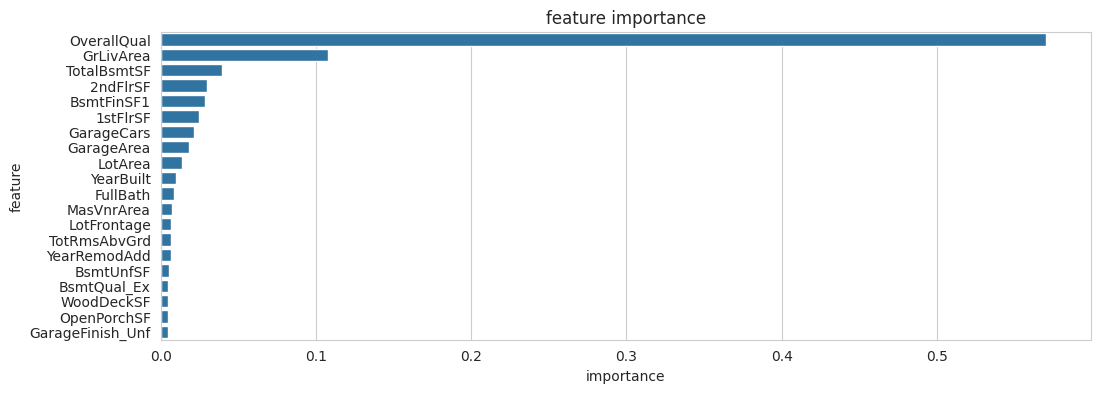

In [31]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 4))
sns.barplot(x=imp_df["mean"].head(20), y=imp_df.index[:20])
plt.title("feature importance")
plt.xlabel("importance")
plt.ylabel("feature")
plt.show()

### ◆ 提出データの作成

In [32]:
# 単一モデルアンサンブルの予測出力の定義
def models_predict(X_test, models):
    print(f"n_models: {len(models)}")
    preds = []

    for model in models:
        pred = model.predict(X_test)
        preds.append(pred)

    preds = np.array(preds)
    preds = np.mean(preds, axis=0)

    return preds

In [33]:
# 単一モデルアンサンブルの予測出力
pred = models_predict(test[FEATURES], models)

n_models: 5


In [34]:
# 提出ファイルの作成
submit = pd.DataFrame({
    "Id": submission["Id"],
    "SalePrice": pred
})

In [35]:
# 提出ファイルの保存
save_path = output_path / "submission.csv"
submit.to_csv(save_path, index=False)

*最終Public Score: 0.14767*


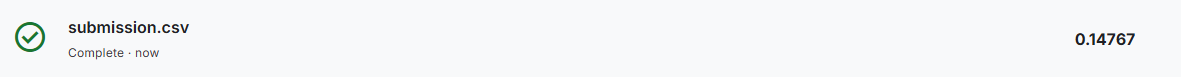

## 〇 まとめ

本ノートブックでは、  
Kaggleコンペティション「**House Prices - Advanced Regression Techniques**」において、  
**ランダムフォレスト(RandomForestRegressor)** と **交差検証(KFold)** を用いたベースライン構築を行いました。  

前処理では欠損値補完・カテゴリ変数のエンコーディングを行い、  
モデル自体は **ハイパーパラメータの調整を行わないシンプルな構成** としています。  
その結果、**Public Score 0.14767** となりました。

## 〇 今後の方針

- Public Score 0.14767  
- カラム数が多く、どれも予測に寄与していると考えられるため、  
特徴量エンジニアリングは行わず **全体を活用する方針** とした。
- LightGBMなど **他の勾配ブースティングモデル** の適用  
- モデルが処理しやすい **データ型の変換方針** の検討  
- 外れ値対応や分布の正規化処理の検討(log1p, yeo-johnsonなど)